In [3]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler


## Read the dataset

In [ ]:
!pip install gdal > /dev/null

In [4]:
!pip install gdown

In [5]:
import gdown
gdown.download("https://drive.google.com/uc?id=1och-QmNa3FAiS-wssgzCwISbmpSezIi_", "dataset.zip", quiet=False)
gdown.extractall("dataset.zip")
path = 'dataset/'

Downloading...
From (uriginal): https://drive.google.com/uc?id=1och-QmNa3FAiS-wssgzCwISbmpSezIi_
From (redirected): https://drive.google.com/uc?id=1och-QmNa3FAiS-wssgzCwISbmpSezIi_&confirm=t&uuid=3ce090bf-aa76-4450-9515-3e4c44efdaed
To: /kaggle/working/dataset.zip
100%|██████████| 1.70G/1.70G [00:14<00:00, 120MB/s] 


In [6]:
!rm /kaggle/working/dataset.zip

In [9]:
path = '/kaggle/working/dataset'

## Prepare the data

In [11]:
# Define the data transformations for the training set
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Define the data transformations for the test set
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load the dataset without applying any transformations
dataset = torchvision.datasets.ImageFolder(root=path)

# Split the dataset into train and test
TRAIN_SIZE = 0.95
TEST_SIZE = 0.05

train_size = int(TRAIN_SIZE * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, (train_size, test_size))

# Apply the data transformations to each dataset
train_data.dataset.transform = train_transforms
test_data.dataset.transform = test_transforms

batch_size = 32
trainLoader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [21]:
train_data.dataset.class_to_idx

{'flooded': 0, 'non-flooded': 1}

## Device

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Availabe device for training is: {device}')

Availabe device for training is: cuda


## Speedups

In [13]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

## Model Architecture

### ResNet18

In [ ]:
# Define ResNet model 
model = models.resnet18(pretrained=True)

#  Modify the first layer to be able to handle our data
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last layer to work with two classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move the model to GPU if possible
model = model.to(device)

# Define loss function, optimizer, and lr schehduler
# criterion: The loss function used for optimization.
criterion = nn.CrossEntropyLoss()
# optimizer: The optimizer to update the model's parameters.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# step_lr_scheduler: The learning rate scheduler for adjusting the learning rate during training.
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


### DenseNet

In [ ]:
# Define DensNet model 
model = models.densenet121(pretrained=True)

# Modify the first layer to be able to handle our data
model.features.conv0 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the last layer to work with two classes
model.classifier = nn.Linear(model.classifier.in_features, 2)

# Move the model to GPU if possible
model = model.to(device)

# Define loss function, optimizer, and lr schehduler
# criterion: The loss function used for optimization.
criterion = nn.CrossEntropyLoss()
# optimizer: The optimizer to update the model's parameters.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# step_lr_scheduler: The learning rate scheduler for adjusting the learning rate during training.
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Resenet50

In [24]:
# Define ResNet model 
model = models.resnet50(pretrained=True)

# Modify the last layer to work with two classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Move the model to GPU if possible
model = model.to(device)

# Define loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model Enhancement 

### Dropout
Dropout is a regularization technique that can help prevent overfitting by randomly disabling neurons during training. It can be added after fully connected layers to reduce the model's reliance on specific features and encourage better generalization.

In [ ]:
# # Add Dropout after the last fully connected layer
# num_features = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_features, 512),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(512, 2)
# )
# # use model.classifier for the densenet


## Training

In [25]:
import time
import copy

def train_model(model, trainloader, validationloader, device, criterion, optimizer, step_lr_scheduler, epochs):
    '''
    This code is designed to train a model, track its performance during training, and return the best model along with the loss and accuracy values.
    '''
    try:
        model = model.to(device)

        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0

        train_acc = []
        train_loss = []
        valid_acc = []
        valid_loss = []

        for epoch in range(epochs):
            print('-' * 80)
            print(f'Epoch {epoch + 1}/{epochs}')

            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()
                    dataloader = trainloader
                    dataset_size = len(trainloader.dataset)
                else:
                    model.eval()
                    dataloader = validationloader
                    dataset_size = len(validationloader.dataset)

                running_loss = 0.0
                running_corrects = 0

                for data in dataloader:
                    # Get the training data items of the current batch
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)

                    with torch.set_grad_enabled(phase == 'train'):
                        # Forward pass
                        outputs = model(inputs)
                        # Predict the current batch
                        _, preds = torch.max(outputs, 1)
                        # Compute loss
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            # Set the gradients of all the parameters of the model to zero
                            optimizer.zero_grad()
                            # Backward propagation to calculate the gradient
                            loss.backward()
                            # Update the NN weights by using the gradient
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    step_lr_scheduler.step()

                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                if phase == 'valid':
                    valid_acc.append(epoch_acc)
                    valid_loss.append(epoch_loss)
                else:
                    train_acc.append(epoch_acc)
                    train_loss.append(epoch_loss)

                print('{} loss: {:.4f} --------------- {} accuracy: {:.4f}'.format(phase, epoch_loss, phase, epoch_acc))

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('-' * 80)
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best validation accuracy: {:4f}'.format(best_acc))

        # load best model weights
        print('Loading final model weights...')
        model.load_state_dict(best_model_wts)
        return model, train_loss, train_acc, valid_loss, valid_acc

    except Exception as e:
        print(f"An error occurred during training: {str(e)}")
        return None, [], [], [], []


In [15]:
import time
import copy

def train_model_no_val(model, trainloader, device, criterion, optimizer, step_lr_scheduler, epochs):
    '''
    This code is designed to train a model and track its performance during training.
    '''
    try:
        model = model.to(device)

        since = time.time()

        train_acc = []
        train_loss = []

        for epoch in range(epochs):
            print('-' * 80)
            print(f'Epoch {epoch + 1}/{epochs}')

            model.train()
            dataloader = trainloader
            dataset_size = len(trainloader.dataset)

            running_loss = 0.0
            running_corrects = 0

            for data in dataloader:
                # Get the training data items of the current batch
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.set_grad_enabled(True):
                    # Forward pass
                    outputs = model(inputs)
                    # Predict the current batch
                    _, preds = torch.max(outputs, 1)
                    # Compute loss
                    loss = criterion(outputs, labels)

                    # Set the gradients of all the parameters of the model to zero
                    optimizer.zero_grad()
                    # Backward propagation to calculate the gradient
                    loss.backward()
                    # Update the NN weights by using the gradient
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            step_lr_scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            train_acc.append(epoch_acc)
            train_loss.append(epoch_loss)

            print('{} loss: {:.4f} --------------- {} accuracy: {:.4f}'.format('train', epoch_loss, 'train', epoch_acc))

        time_elapsed = time.time() - since
        print('-' * 80)
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        return model, train_loss, train_acc

    except Exception as e:
        print(f"An error occurred during training: {str(e)}")
        return None, [], []


In [26]:
model, train_loss, train_acc, valid_loss, valid_acc = train_model(model, trainLoader, testLoader, device, criterion, optimizer, step_lr_scheduler, epochs=15)
# model, train_loss, train_acc = train_model_no_val(model, trainLoader, device, criterion, optimizer, step_lr_scheduler, epochs=15)

--------------------------------------------------------------------------------
Epoch 1/15
train loss: 0.3695 --------------- train accuracy: 0.8617
valid loss: 0.5576 --------------- valid accuracy: 0.8723
--------------------------------------------------------------------------------
Epoch 2/15
train loss: 0.1880 --------------- train accuracy: 0.9371
valid loss: 0.3616 --------------- valid accuracy: 0.8936
--------------------------------------------------------------------------------
Epoch 3/15
train loss: 0.1551 --------------- train accuracy: 0.9463
valid loss: 0.0931 --------------- valid accuracy: 0.9574
--------------------------------------------------------------------------------
Epoch 4/15
train loss: 0.1019 --------------- train accuracy: 0.9680
valid loss: 0.1032 --------------- valid accuracy: 0.9574
--------------------------------------------------------------------------------
Epoch 5/15
train loss: 0.1755 --------------- train accuracy: 0.9349
valid loss: 0.2068

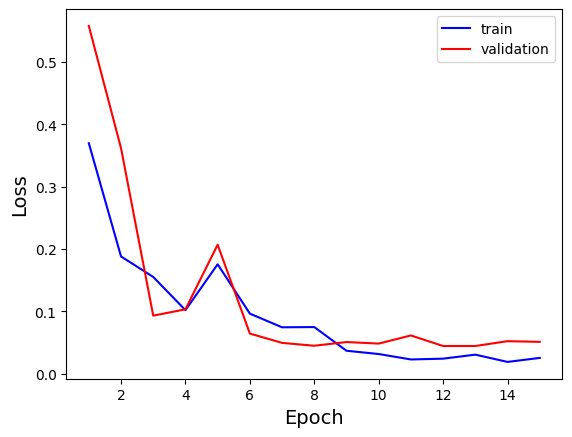

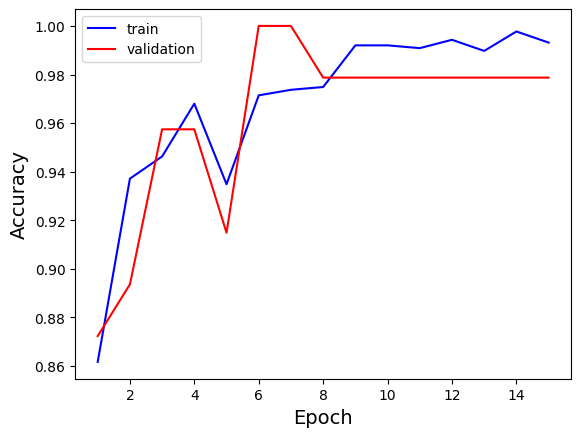

In [39]:
epochs = 15
values = [i for i in range(1, epochs + 1)]
import matplotlib.pyplot as plt
# train_acc_cpu = train_acc.cpu()
# train_acc_numpy = train_acc.numpy()
# valid_acc_cpu = valid_acc.cpu()
# valid_acc_numpy = valid_acc.numpy()
# Move each tensor in the list to the CPU and convert it to a numpy array
train_acc_numpy = [x.cpu().numpy() for x in train_acc]
# Move each tensor in the list to the CPU and convert it to a numpy array
valid_acc_numpy = [x.cpu().numpy() for x in valid_acc]



plt.style.use('default')
plt.plot(values, train_loss, color='b', label='train')
plt.plot(values, valid_loss, color='r', label='validation')
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend()
plt.show()
plt.style.use('default')
plt.plot(values, train_acc_numpy, color='b', label='train')
plt.plot(values, valid_acc_numpy, color='r', label='validation')
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend()
plt.show()

## Evaluation

In [27]:
def predict(model, dataloader, device):
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            
    return np.asarray(y_pred), np.asarray(y_true)

In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score

# Test the model on the test dataset
y_pred, y_true = predict(model, testLoader, device)
        
# Evalaution        
# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('F1 Score: {:.2f}'.format(f1))

# Show the whole report
classification_report = classification_report(y_true, y_pred)
print(classification_report)


Accuracy: 100.00%
F1 Score: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        21

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



## Combine Train and Val datasets

In [ ]:
from torch.utils.data import ConcatDataset

# Combine the training and validation data into a single dataset
train_val_data = ConcatDataset([train_data, validation_data])

# Create a DataLoader for the combined dataset
train_val_loader = torch.utils.data.DataLoader(train_val_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
print(train_val_data.cummulative_sizes)

## 5-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold

# Define the number of folds
k = 3

# Create a KFold object
kfold = KFold(n_splits=k, shuffle=True)

# Initialize a variable to track the total validation accuracy
total_valid_acc = 0.0

# Save the initial state of the model
initial_model_state = copy.deepcopy(model.state_dict())

# Split the training data into k folds
for fold, (train_index, validation_index) in enumerate(kfold.split(train_data)):
    print(f'Fold {fold + 1}/{k}')

    # Reset the model to its initial state
    model.load_state_dict(initial_model_state)
    
    # Create a Subset object for the current train and validation sets
    train_subset = torch.utils.data.Subset(train_val_data, train_index)
    validation_subset = torch.utils.data.Subset(train_val_data, validation_index)
    
    # Create DataLoaders for the current train and validation sets
    trainLoader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    validationLoader = torch.utils.data.DataLoader(validation_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Train the model using the current train and validation sets
    model, train_loss, train_acc, valid_loss, valid_acc = train_model(model, trainLoader, validationLoader, device, criterion, optimizer, step_lr_scheduler, epochs=15)

    # Update the total validation accuracy
    total_valid_acc += valid_acc[-1]

# Compute the average validation accuracy over the k folds
avg_valid_acc = total_valid_acc / k
print(f'Average validation accuracy: {avg_valid_acc:.4f}')

Fold 1/3

--------------------------------------------------------------------------------

Epoch 1/15

train loss: 0.5436 --------------- train accuracy: 0.7189

valid loss: 0.5107 --------------- valid accuracy: 0.7439

--------------------------------------------------------------------------------

Epoch 2/15

train loss: 0.3330 --------------- train accuracy: 0.8635

valid loss: 0.3690 --------------- valid accuracy: 0.8455

--------------------------------------------------------------------------------

Epoch 3/15

train loss: 0.2456 --------------- train accuracy: 0.9043

valid loss: 0.2880 --------------- valid accuracy: 0.8984

--------------------------------------------------------------------------------

Epoch 4/15

train loss: 0.1481 --------------- train accuracy: 0.9552

valid loss: 0.2639 --------------- valid accuracy: 0.8984

--------------------------------------------------------------------------------

Epoch 5/15

train loss: 0.0982 --------------- train accurac

## Saving the model

In [40]:
# save model
torch.save(model.state_dict(), 'resnet50_95train.pth')

In [48]:
from IPython.display import FileLink
FileLink(r'resnet50_95train.pth')

/kaggle/working/resnet50_95train.pth